<a href="https://colab.research.google.com/github/tleitch/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/02_market_and_fundamental_data/03_data_providers/01_pandas_datareader_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remote data access using pandas

The pandas library enables access to data displayed on websites using the `read_html()` function and access to the API endpoints of various data providers through the related `pandas-datareader` library.

## Imports & Settings

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
!pip install mplfinance
%matplotlib inline
import os
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

## Download html table with SP500 constituents

The download of the content of one or more html tables works as follows, for instance for the constituents of the S&P500 index from Wikipedia

In [36]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

In [37]:
sp500_constituents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 505 non-null    object
 1   Security               505 non-null    object
 2   SEC filings            505 non-null    object
 3   GICS Sector            505 non-null    object
 4   GICS Sub-Industry      505 non-null    object
 5   Headquarters Location  505 non-null    object
 6   Date first added       453 non-null    object
 7   CIK                    505 non-null    int64 
 8   Founded                505 non-null    object
dtypes: int64(1), object(8)
memory usage: 35.6+ KB


In [38]:
sp500_constituents.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


## pandas-datareader for Market Data

`pandas` used to facilitate access to data providers' APIs directly, but this functionality has moved to the related pandas-datareader library. The stability of the APIs varies with provider policies, and as of June 2o18 at version 0.7, the following sources are available

See [documentation](https://pandas-datareader.readthedocs.io/en/latest/); functionality frequently changes as underlying provider APIs evolve.

### Yahoo Finance

In [39]:
start = '2014'
end = datetime(2017, 5, 24)

yahoo= web.DataReader('FB', 'yahoo', start=start, end=end)
yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 855 entries, 2014-01-02 to 2017-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       855 non-null    float64
 1   Low        855 non-null    float64
 2   Open       855 non-null    float64
 3   Close      855 non-null    float64
 4   Volume     855 non-null    int64  
 5   Adj Close  855 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 46.8 KB


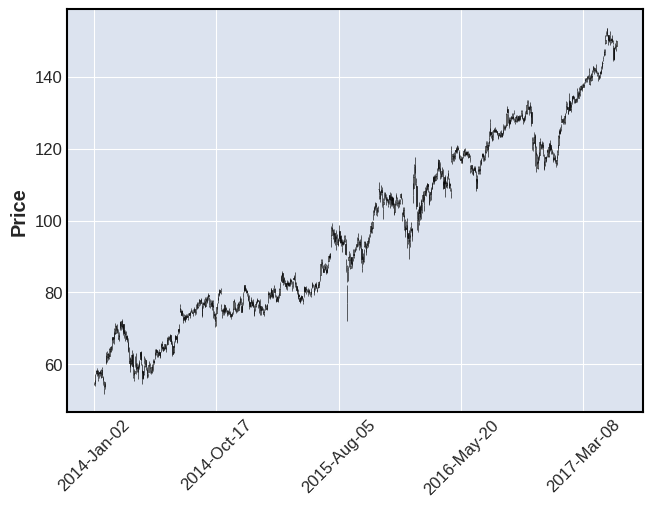

<Figure size 640x480 with 0 Axes>

In [40]:
mpf.plot(yahoo.drop('Adj Close', axis=1), type='candle')
plt.tight_layout()

### IEX

IEX is an alternative exchange started in response to the HFT controversy and portrayed in Michael Lewis' controversial Flash Boys. It aims to slow down the speed of trading to create a more level playing field and has been growing rapidly since launch in 2016 while still small with a market share of around 2.5% in June 2018.

> **Note:** IEX now requires an [API](https://iexcloud.io/) key after registration for (free) account that you can store as environment variable and retrieve as illustrated below, or pass directly via keyword argument to `pandas_datareader`.

In [41]:
#IEX_API_KEY=os.getenv('IEX_API_KEY')

In [42]:
start = datetime(2015, 2, 9)
# end = datetime(2017, 5, 24)

iex = web.DataReader('FB', 'iex', start, api_key="")
iex.info()

ValueError: ignored

In [ ]:
iex.tail()

In [ ]:
sns.set_style('whitegrid')
iex.close.plot(figsize=(14, 5))
sns.despine()

#### Book Data

In addition to historical EOD price and volume data, IEX provides real-time depth of book quotations that offer an aggregated size of orders by price and side. This service also includes last trade price and size information.

DEEP is used to receive real-time depth of book quotations direct from IEX. The depth of book quotations received via DEEP provide an aggregated size of resting displayed orders at a price and side, and do not indicate the size or number of individual orders at any price level. Non-displayed orders and non-displayed portions of reserve orders are not represented in DEEP.

DEEP also provides last trade price and size information. Trades resulting from either displayed or non-displayed orders matching on IEX will be reported. Routed executions will not be reported.

Only works on trading days.

In [ ]:
book = web.get_iex_book('AAPL')

In [ ]:
list(book.keys())

In [ ]:
orders = pd.concat([pd.DataFrame(book[side]).assign(side=side) for side in ['bids', 'asks']])
orders.head()

In [ ]:
for key in book.keys():
    try:
        print(f'\n{key}')
        print(pd.DataFrame(book[key]))
    except:
        print(book[key])

In [ ]:
pd.DataFrame(book['trades']).head()

### Quandl

Obtain Quandl [API Key](https://www.quandl.com/tools/api) and store in environment variable as `QUANDL_API_KEY`.

In [ ]:
symbol = 'FB.US'

#quandl = web.DataReader(symbol, 'quandl', '2015-01-01')
#quandl.info()

### FRED

In [43]:
start = datetime(2010, 1, 1)

end = datetime(2013, 1, 27)

gdp = web.DataReader('GDP', 'fred', start, end)

gdp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2010-01-01 to 2013-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     13 non-null     float64
dtypes: float64(1)
memory usage: 208.0 bytes


In [ ]:
inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred', start, end)
inflation.info()

### Fama/French

In [ ]:
from pandas_datareader.famafrench import get_available_datasets
get_available_datasets()

In [ ]:
ds = web.DataReader('5_Industry_Portfolios', 'famafrench')
print(ds['DESCR'])

### World Bank

In [ ]:
from pandas_datareader import wb
gdp_variables = wb.search('gdp.*capita.*const')
gdp_variables.head()

In [ ]:
wb_data = wb.download(indicator='NY.GDP.PCAP.KD', 
                      country=['US', 'CA', 'MX'], 
                      start=1990, 
                      end=2019)
wb_data.head()

### OECD

In [ ]:
df = web.DataReader('TUD', 'oecd', start='2010', end='2019')
df[['Japan', 'United States']]



### Stooq

Google finance stopped providing common index data download. The Stooq site had this data for download for a while but is currently broken, awaiting release of [fix](https://github.com/pydata/pandas-datareader/issues/594)

In [ ]:
index_url = 'https://stooq.com/t/'
ix = pd.read_html(index_url)
len(ix)

In [ ]:
sp500_stooq = web.DataReader('^SPX', 'stooq')
sp500_stooq.info()

In [ ]:
sp500_stooq.head()

In [ ]:
sp500_stooq.Close.plot(figsize=(14,4))
sns.despine()
plt.tight_layout()

### NASDAQ Symbols

In [ ]:
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
symbols = get_nasdaq_symbols()
symbols.info()

### Tiingo

Requires [signing up](https://api.tiingo.com/) and storing API key in environment

In [ ]:
df = web.get_data_tiingo('GOOG', api_key=os.getenv('TIINGO_API_KEY'))

In [ ]:
df.info()